## Homework 5: Parallel bifurcation and spectrogram

### Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import os
import pickle
import random

from plotly import graph_objs as go
from plotly import express as px
from scipy import fft

from threading import Thread
from multiprocessing import Pool, Process
import time
import timeit

import warnings
warnings.filterwarnings('ignore')

### Task 5.1

#### Functions

In [ ]:
def logistic_map_step(x, r):
    return r*x * (1 - x)

def bifurcation_map(r, m: int=1, n: int=1):
    '''
    m - number of last values
    n - number of first values
    '''
    Y = np.zeros((len(r), m))
    for i in range(len(r)):
        Y[i, 0] = np.random.random()
        for j in range(m+n-1):
            if j >= n:
                Y[i, j-n+1] = logistic_map_step(Y[i, j-n], r[i])
            else:
                Y[i, 0] = logistic_map_step(Y[i, 0], r[i])
    
    return Y

def parallel_bifurcation_map(r_params):
    global m, n
    Y = np.zeros(m)
    Y[0] = np.random.random()
    for j in range(m+n-1):
        if j >= n:
            Y[j-n+1] = logistic_map_step(Y[j-n], r_params)
        else:
            Y[0] = logistic_map_step(Y[0], r_params)
    return Y

#### Parameters

In [99]:
size = 10001
m=100
n=5000
r_params = np.linspace(1, 4, size)

#### Implementation: 1 process

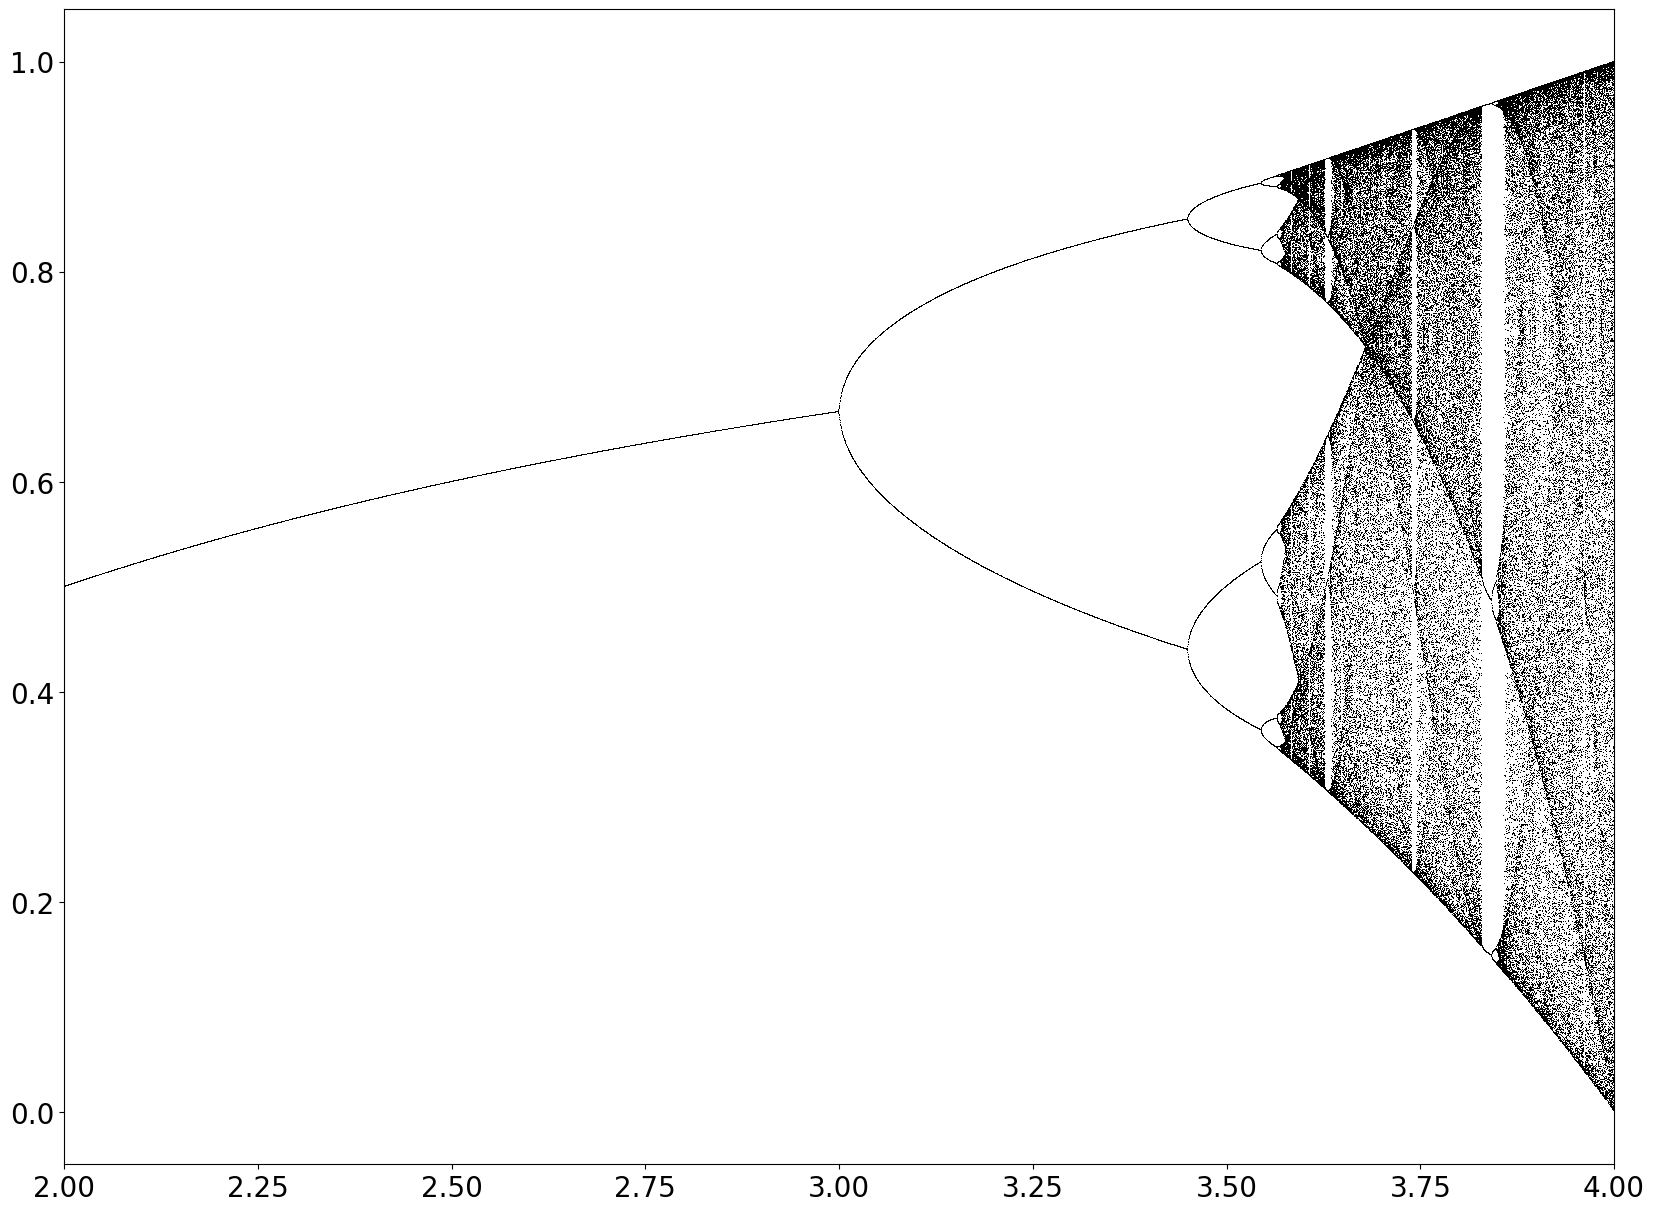

In [54]:
direct_bifmap_results = bifurcation_map(
    r=r_params,
    m=m,
    n=n,
)
fig = plt.figure(figsize=[20, 15],)
plt.plot(r_params, direct_bifmap_results, ls='', marker=',', color='black')
plt.xlim([2, 4])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### Implementation: 2 processes

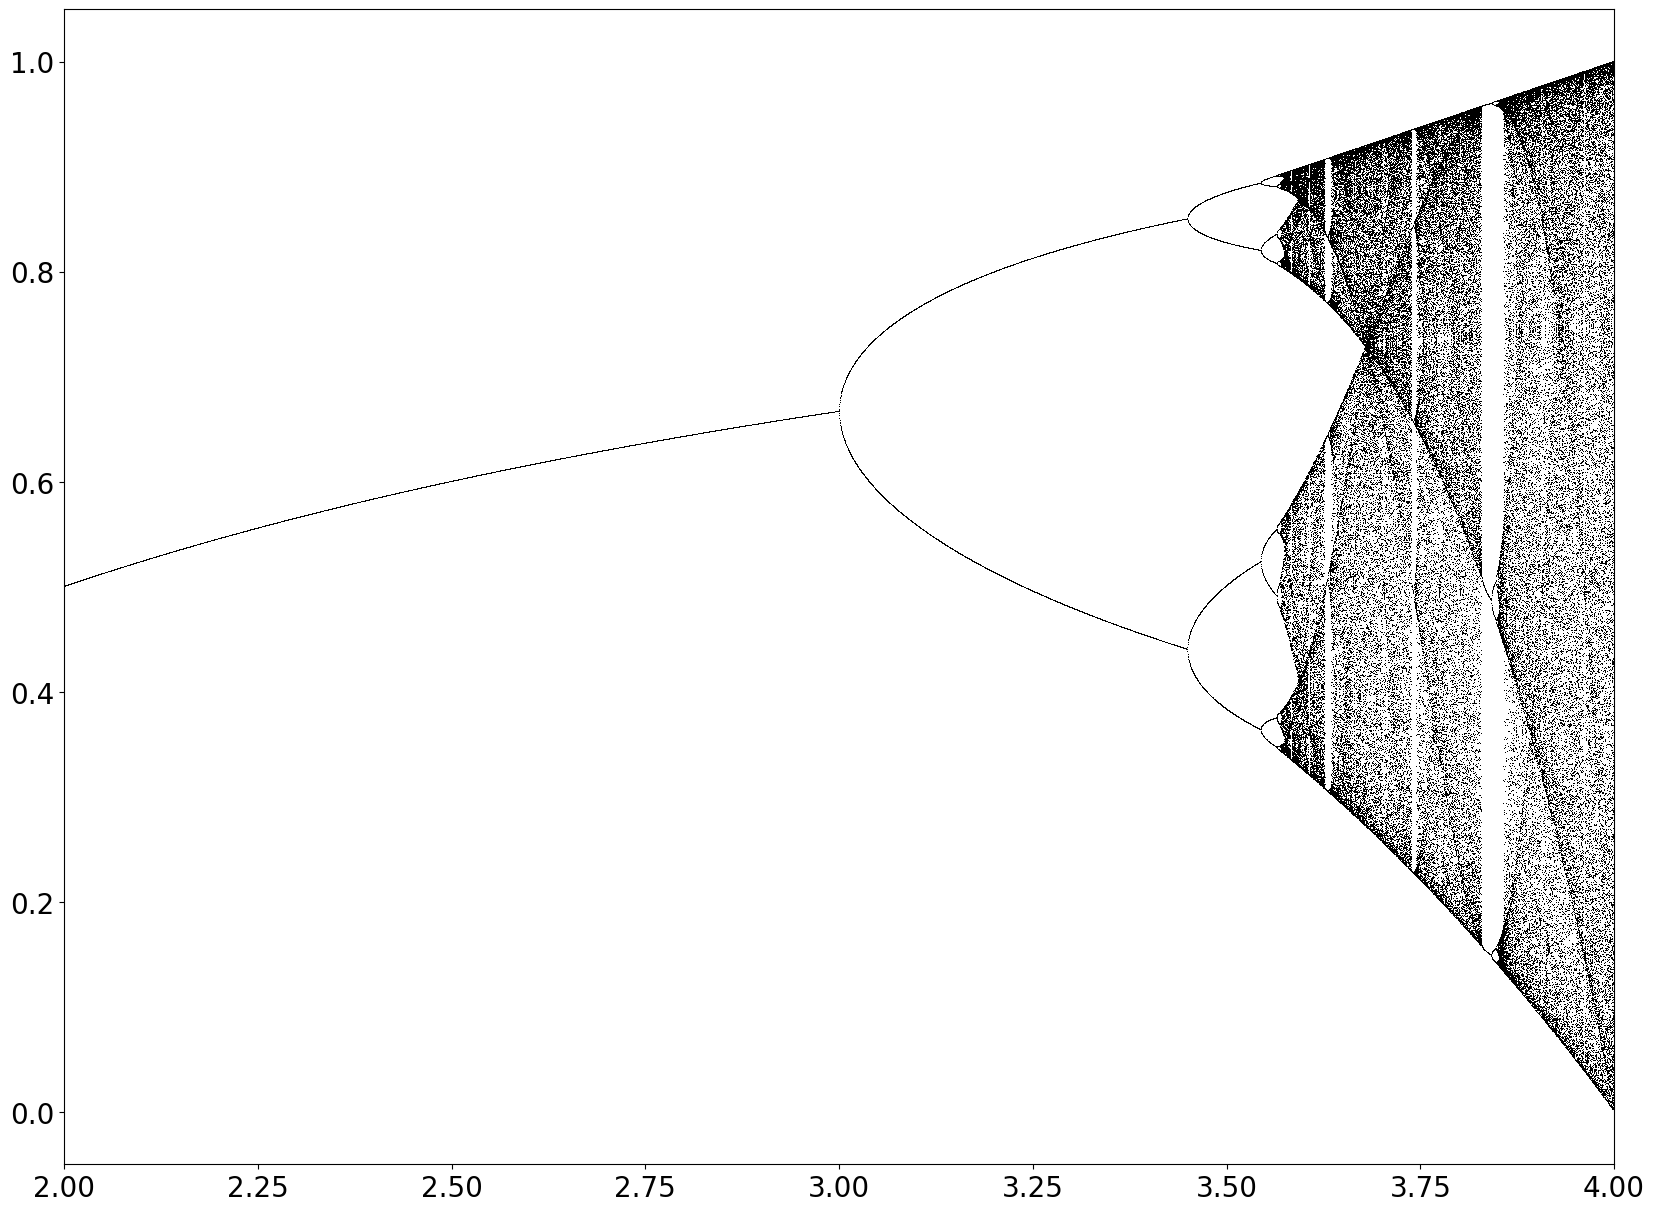

In [100]:
with Pool(processes=2) as pool:
    Y = pool.map(func=parallel_bifurcation_map, iterable=r_params)

fig = plt.figure(figsize=[20, 15], )

plt.plot(r_params, Y, ls='', marker=',', color='black')
plt.xlim([2, 4])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Task 5.2

In [120]:
def pool_procs(func, procs, iterable_params):
    with Pool(processes=procs) as pool:
        pool.map(func=func, iterable=iterable_params)

In [ ]:
num_procs = np.zeros(7, dtype=np.int16)
num_procs[0] = int(1)
num_procs[1:] = np.arange(2, 13, 2)
exec_time = np.zeros(len(num_procs))
for i, procs in enumerate(num_procs):
    exec_time[i] = timeit.timeit(lambda: pool_procs(parallel_bifurcation_map, procs, r_params), number=1)

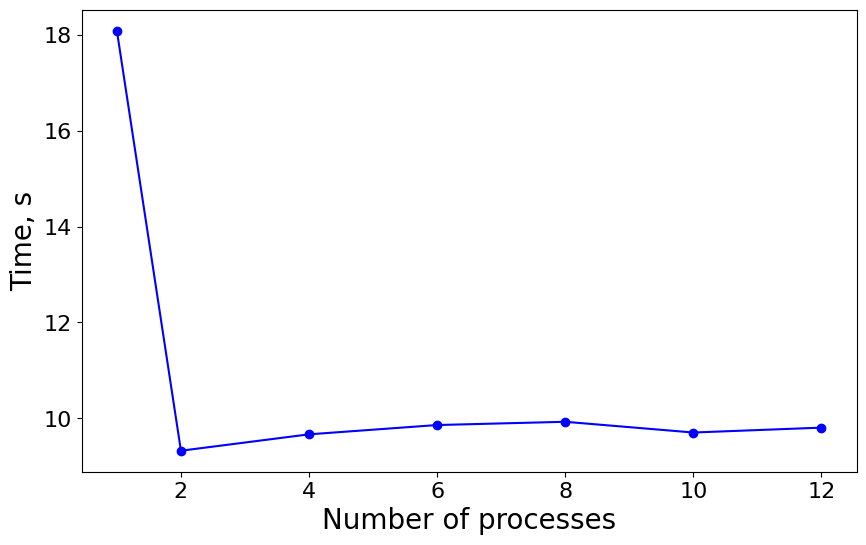

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(num_procs, exec_time, marker='o', color='blue')
plt.xlabel('Number of processes', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Time, s', fontsize=20)
plt.yticks(fontsize=16)
plt.show()

### Task 5.3

#### Initial parameters

In [16]:
t=np.linspace(-20*2*np.pi, 20*2*np.pi, 2**14)
# 1st wave packet
y1=np.sin(t)*np.exp(-t**2/2/20**2)
# 2nd wave packet
y2=y1+np.sin(3*t)*np.exp(-(t-5*2*np.pi)**2/2/20**2)
# 3rd wave packet
y3=y2+np.sin(5.5*t)*np.exp(-(t-10*2*np.pi)**2/2/5**2)
# 4st wave packet
signal=y3+np.sin(4*t)*np.exp(-(t-7*2*np.pi)**2/2/5**2)

#### Functions

In [8]:
def specsgram(nwindowstep, window_width: int=25):
    global t, step, signal

    end = nwindowstep*step + t[0]

    window_func = np.exp(-(t-end)**2 / 2 / window_width**2)

    windowed_signal = signal * window_func
    spectrum = np.fft.fft(windowed_signal)
    w = np.fft.fftfreq(len(windowed_signal), d=(t[1]-t[0]) / (2*np.pi))

    freq_range = np.logical_and(w > 0, w < 6)
    w = w[freq_range]        
    intensity = np.abs(spectrum[freq_range])**2
    return end, w, intensity

def get_specgram(results):
    plt.figure(figsize=(10, 6))
    for end, w, intensity in results:
        plt.scatter([end] * len(w), w, c=intensity)
    plt.title("Spectrogram")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")

#### Implementation: 1 process

In [14]:
nwindowsteps = 1000
window_width = 25
step = (t[-1] - t[0]) / nwindowsteps

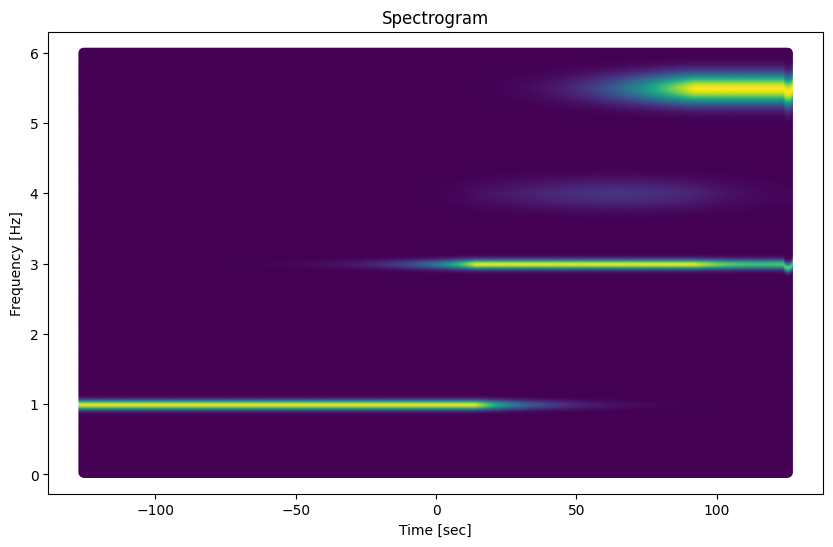

In [12]:
direct_results = []
for nwindowstep in np.arange(1000):
    direct_results.append(specsgram(nwindowstep=nwindowstep))
get_specgram(direct_results)

#### Implementation: 2 processes

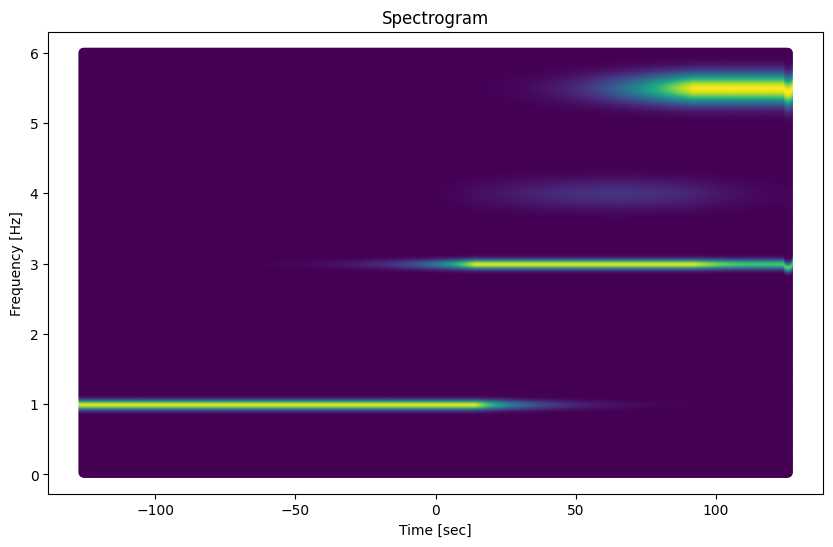

In [15]:
with Pool(processes=2) as pool:
    paral_results = pool.map(func=specsgram, iterable=np.arange(1001))
get_specgram(paral_results)

### Task 5.4

In [17]:
nwindowsteps = 50000
window_width = 25
step = (t[-1] - t[0]) / nwindowsteps

In [128]:
num_procs_2 = np.zeros(7, dtype=np.int16)
num_procs_2[0] = int(1)
num_procs_2[1:] = np.arange(2, 13, 2)
exec_time_2 = np.zeros(len(num_procs_2))
for i, procs in enumerate(num_procs_2):
    exec_time_2[i] = timeit.timeit(lambda: pool_procs(specsgram, procs, np.arange(nwindowsteps)), number=1)

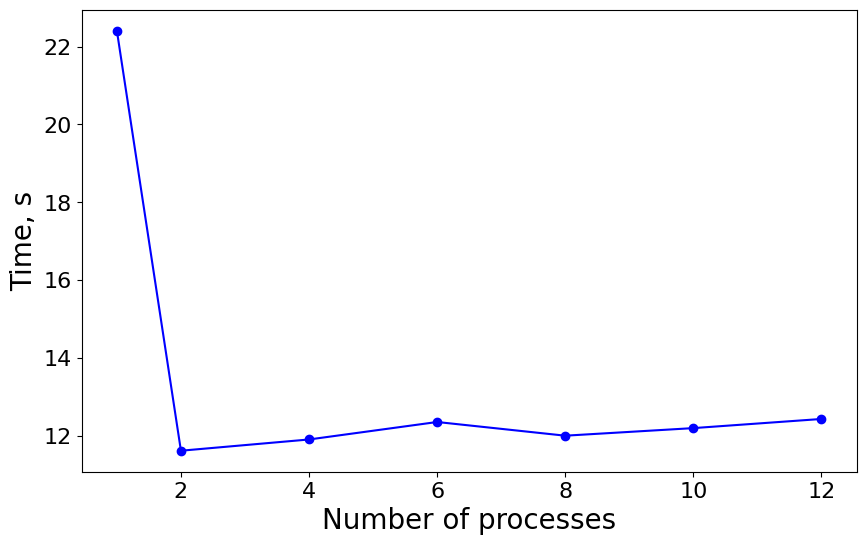

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(num_procs_2, exec_time_2, marker='o', color='blue')
plt.xlabel('Number of processes', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Time, s', fontsize=20)
plt.yticks(fontsize=16)
plt.show()